In [100]:
import torchdiffeq
import numpy as np
import numpy.random as npr
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
from torchdiffeq import odeint
import torch.nn as nn
import torch.optim as optim

In [108]:
# Generate spiral dataset
data_size = 1000
batch_time = 20
niters = 200
batch_size = 16
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
t_grid = torch.linspace(0, 25, data_size).to(device)
true_y0 = torch.tensor([[2., 0.]]).to(device)
true_A = torch.tensor([[-0.1, 2.0], [-2.0, -0.1]]).to(device)

cuda:0


In [109]:
class Lambda(nn.Module):
    def forward(self, t, y):
        return torch.mm(y**3, true_A) # matrix mult

with torch.no_grad():
    true_y = odeint(Lambda(), true_y0, t_grid, method='dopri5').view(data_size, -1)

true_y.size()

torch.Size([1000, 2])

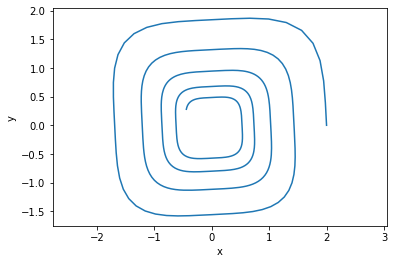

In [110]:
def plot_spiral(trajectories):
    for path in trajectories:
        plt.plot(*path.T)
    plt.axis("equal")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

plot_spiral([true_y.cpu()])

In [111]:
# batch generator
def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
    batch_y0 = true_y[s]  # (M, D)
    batch_t = t_grid[:batch_time]  # (T)
    batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_y0.to(device), batch_t.to(device), batch_y.to(device)

In [112]:
class ODEModel(nn.Module):

    def __init__(self):
        super(ODEModel, self).__init__()

        self.lin1 = nn.Linear(2,50)
        self.lin2 = nn.Linear(50,2)
        
        self.optimizer = optim.RMSprop(self.parameters(), lr=1e-3)

    def forward(self, t, y):
        h = y**3
        h = self.lin1(h)
        h = self.lin2(h)
        return h

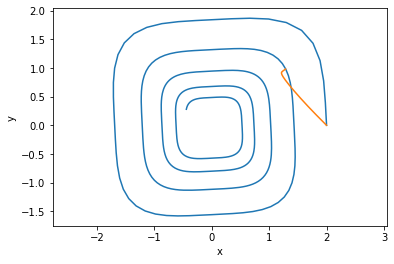

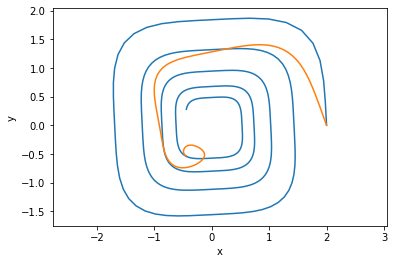

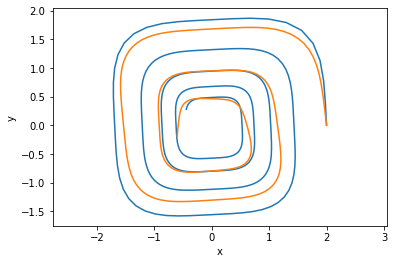

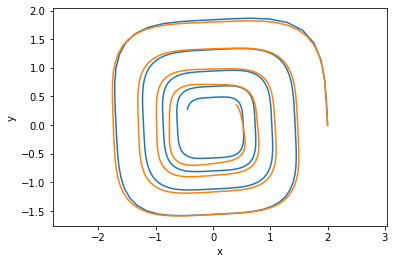

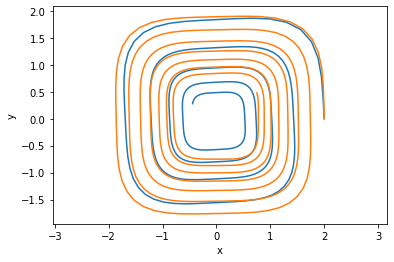

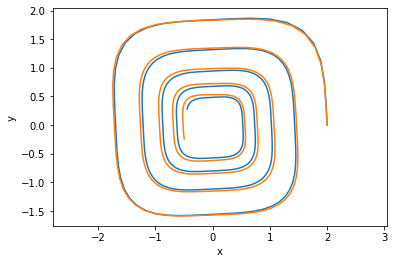

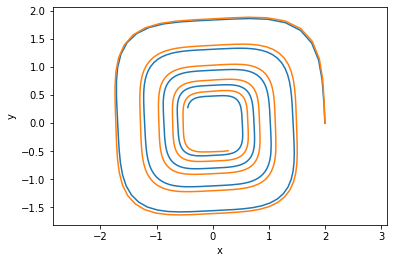

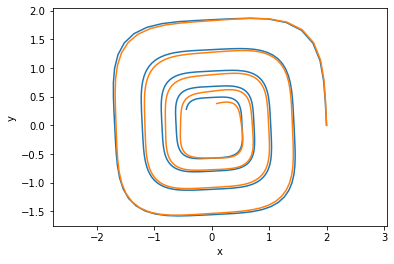

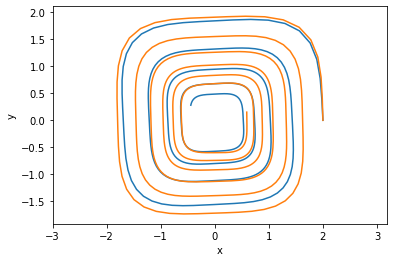

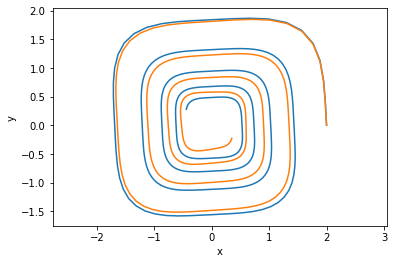

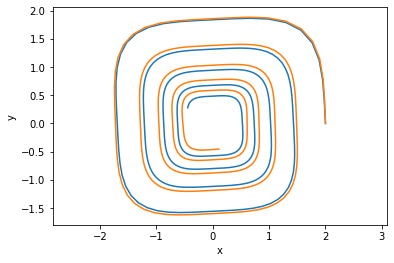

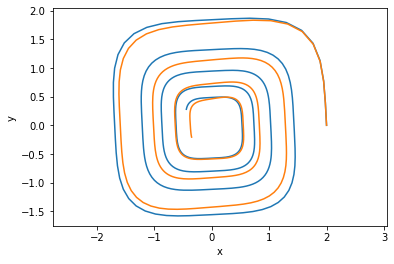

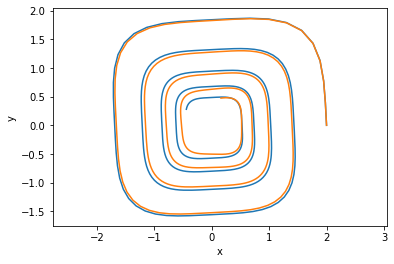

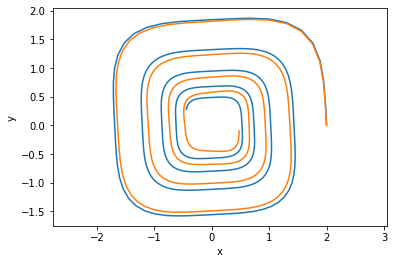

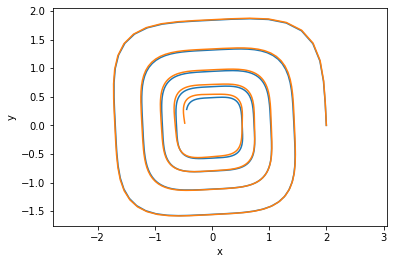

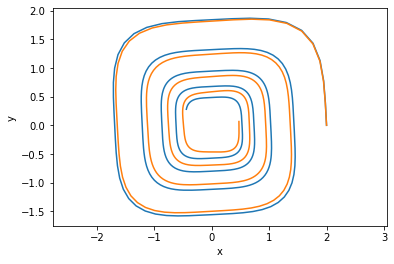

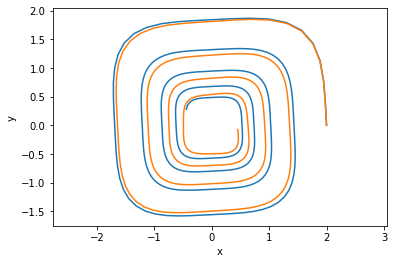

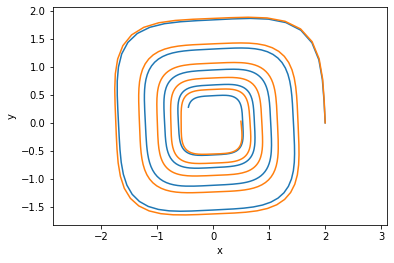

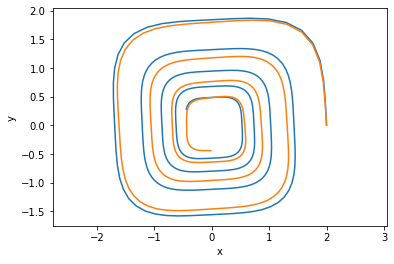

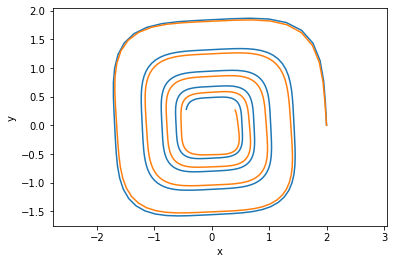

In [114]:
model = ODEModel().to(device)

loss_history = []
for step in range(niters):
    model.optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch()
    pred_y = odeint(model, batch_y0, batch_t).to(device)
    loss = torch.mean(torch.abs(pred_y - batch_y))
    loss_history.append(loss.item())
    loss.backward()
    model.optimizer.step()
    
    if step % 10 == 0:
        with torch.no_grad():
            pred_y = odeint(model, true_y0, t_grid)
            loss = torch.mean(torch.abs(pred_y - true_y))
            plot_spiral([true_y.cpu(), pred_y.detach().cpu().view(data_size, -1)])
